 Before Mitigation: {'Demographic Parity Diff': np.float64(0.027108587796020683), 'Disparate Impact Ratio': np.float64(0.8815510112861772), 'Equal Opportunity Diff': np.float64(0.027108587796020683)}


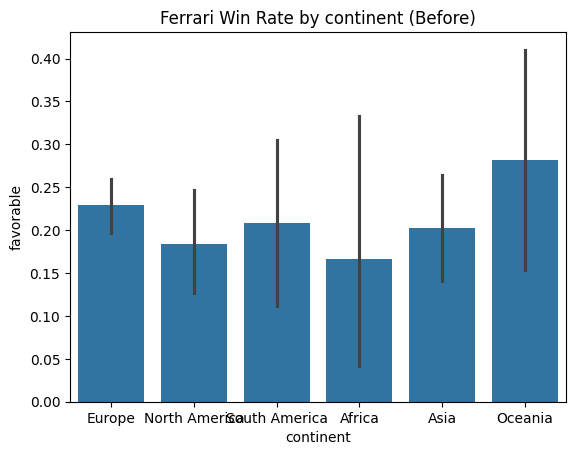


 Model Accuracy After Mitigation: 0.7694174757281553

📊 After Mitigation: {'Demographic Parity Diff': np.float64(0.04081632653061226), 'Disparate Impact Ratio': np.float64(0.8216560509554139), 'Equal Opportunity Diff': np.float64(0.04081632653061226)}


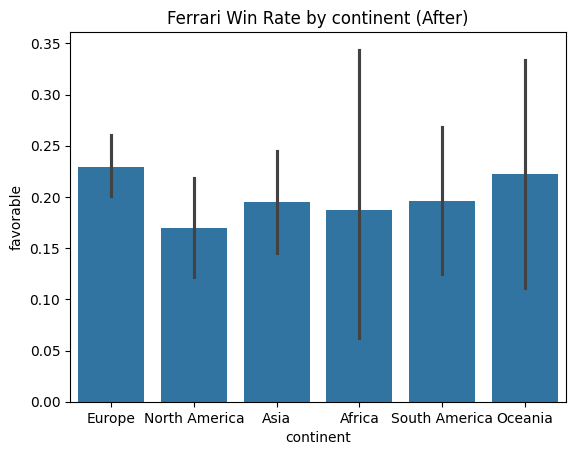


 Comparison:
         Demographic Parity Diff  Disparate Impact Ratio  \
Before                 0.027109                0.881551   
After                  0.040816                0.821656   

        Equal Opportunity Diff  
Before                0.027109  
After                 0.040816  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Load dataset
df = pd.read_csv('/content/winners_f1_1950_2025_v2.csv')


# 'continent' is the sensitive attribute for group fairness analysis
# 'team' column is used to define favorable outcome as winning with Ferrari
# "favorable" column = 1 if team is Ferrari, else 0
df['favorable'] = (df['team'] == 'Ferrari').astype(int)

sensitive = 'continent'
outcome = 'favorable'  # binary variable indicating Ferrari wins (favorable)

def fairness_metrics(data, s=sensitive, y=outcome):
    # g1 = outcome values for first group in sensitive attribute
    # g0 = outcome values for all other groups
    g1, g0 = data[data[s] == data[s].unique()[0]][y], data[data[s] != data[s].unique()[0]][y]
    return {
        "Demographic Parity Diff": abs(g1.mean() - g0.mean()),  # difference in favorable outcome rates
        "Disparate Impact Ratio": g0.mean() / g1.mean() if g1.mean() > 0 else 0,  # ratio < 1 suggests bias
        "Equal Opportunity Diff": abs(g1.mean() - g0.mean())  # same as Dem Parity Diff here
    }


# Before mitigation printout and plot: shows Ferrari win disparity by continent
print(" Before Mitigation:", fairness_metrics(df))
sns.barplot(x=df[sensitive], y=df[outcome])
plt.title(f"Ferrari Win Rate by {sensitive} (Before)")
plt.show()


# Mitigation: balance dataset by oversampling minority continent groups
majority_grp = df[sensitive].value_counts().idxmax()
df_majority = df[df[sensitive] == majority_grp]
df_minority = df[df[sensitive] != majority_grp]
df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)
df_bal = pd.concat([df_majority, df_minority_upsampled])


# Train logistic regression model on balanced data
X_train, X_test, y_train, y_test = train_test_split(df_bal.drop(columns=[outcome]), df_bal[outcome], test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train.select_dtypes(include=[np.number]), y_train)
y_pred = model.predict(X_test.select_dtypes(include=[np.number]))
acc = accuracy_score(y_test, y_pred)
print("\n Model Accuracy After Mitigation:", acc)


# After mitigation printout and plot
print("\n📊 After Mitigation:", fairness_metrics(df_bal))
sns.barplot(x=df_bal[sensitive], y=df_bal[outcome])
plt.title(f"Ferrari Win Rate by {sensitive} (After)")
plt.show()


# Comparison of fairness metrics before vs after mitigation
comparison = pd.DataFrame([fairness_metrics(df), fairness_metrics(df_bal)], index=["Before", "After"])
print("\n Comparison:\n", comparison)
